## voice gender recgonition



## Table of Contents
- [Part I - Data Cleaning](#data_cleaning)
- [Part II - Modeling](#modeling)
- [Part III - feature extraction](#feature_extraction)






<a id='data_cleaning'></a>
### Part I - Data Cleaning

To get started, let's import our libraries.

In [10]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

`1.` Now, read in the `voice.csv` data. Store it in `df`. 

a. Reading the dataset and taking a look at the top few rows:

In [11]:
voice = pd.read_csv('voice.csv')

b. taking all the columns of the csv file.

In [12]:
X = voice.iloc[:,:-1].values
y = voice.iloc[:,-1:].values

 Checking Outliers in voice

- Now we plot box and whisker to check if there is outliers in the dataset.

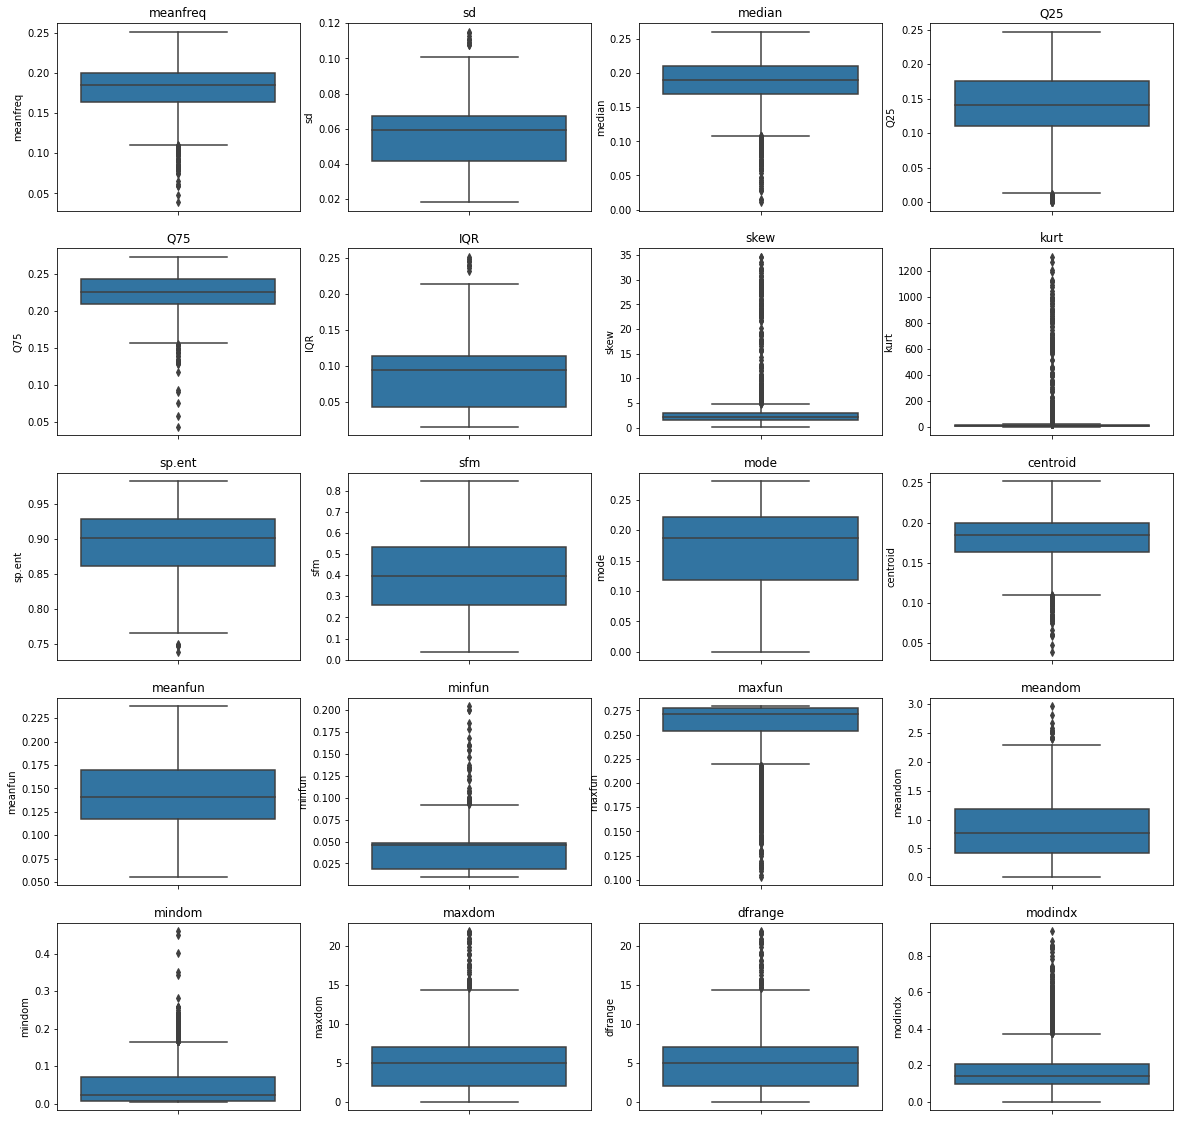

In [13]:
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(20,20))
n = 0
z = 0
for i in voice.columns[:20]:
    sns.boxplot(voice[i],orient='v',ax= axes[z,n],)
    axes[z,n].set_title(i)
    n+=1
    if(n == 4):
        n=0
        z+=1

c.function to plot the confusion matrix. 

In [70]:
def plot_confusion_matrix(y_test,y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    cm = cm.rename(columns={0: 'Male',1:'Female'}, index={0: 'Male',1:'Female'})
    sns.heatmap(cm,annot=True,cmap='Blues', fmt='g');

d. function to plot the learning curves.

In [15]:
def plot_learning_curve (estimator,X,y,cv,scoring ='accuracy',n_jobs=-1,train_size=np.linspace(0.01, 1.0, 50)):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=cv,
                                                        # Evaluation metric
                                                        scoring=scoring)
                                                    
                                                    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

e. function to check which hyper parameter will give the highest accuracy.

In [16]:
def gridSearch(estimator, X_train,y_train,X_test,y_test,*args):
    score = {'model_name':[],'accuracy':[],'params': []}
    for i in args[0]:
        for z in args[1]:
            if (type(estimator).__name__ == 'SVC'):
                estimator.set_params(kernel=i,gamma='scale',C= z)
            elif (type(estimator).__name__ == 'RandomForestClassifier'):
                estimator.set_params(n_estimators= i, criterion= z)
            else:
                estimator.set_params(penalty = i , solver = z)
                
            estimator.fit(X_train,y_train)
            y_pred = estimator.predict(X_test)
            score['model_name'].append(type(estimator).__name__)
            score['accuracy'].append(metrics.accuracy_score(y_test,y_pred))
            score['params'].append((i,z))

    return pd.DataFrame(score)

f. This creates a binary column for each category and returns a sparse matrix or dense array

In [17]:
oneHotEncoder = OneHotEncoder(sparse=False)
y = oneHotEncoder.fit_transform(y)
y_final = []
for z in y:
    y_final.append(z[0])
y = y_final

g. Splitting the dataset into the Training set and Test set.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

h. Standardize features by removing the mean and scaling to unit variance

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<a id='modeling'></a>
### Part II - Modeling

i. Fitting SVM to the Training set.

In [22]:
from sklearn.svm import SVC
kernel =  ['rbf','linear','sigmoid']
C = [1,10,20]
scoresDf = gridSearch(SVC(random_state = 0),X_train,y_train,X_test,y_test,kernel,C)

In [25]:
scoresDf.sort_values(by='accuracy',ascending=False)

,model_name,accuracy,params
2,SVC,0.987374,"(rbf, 20)"
1,SVC,0.986111,"(rbf, 10)"
0,SVC,0.984848,"(rbf, 1)"
3,SVC,0.979798,"(linear, 1)"
4,SVC,0.978535,"(linear, 10)"
5,SVC,0.978535,"(linear, 20)"
6,SVC,0.791667,"(sigmoid, 1)"
8,SVC,0.786616,"(sigmoid, 20)"
7,SVC,0.782828,"(sigmoid, 10)"


In [26]:
classifier = SVC(kernel='rbf',C=20,gamma='scale',random_state=0)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
metrics.accuracy_score(y_test,y_pred)

0.9873737373737373

- learning curve of SVC.


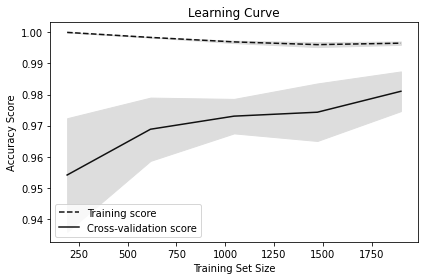

In [14]:
plot_learning_curve(classifier,X_train,y_train,5)

- confusion matrix of SVC.

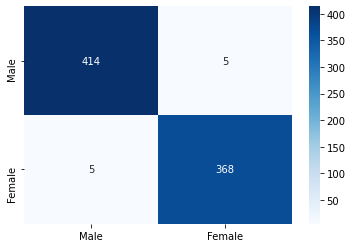

In [27]:
plot_confusion_matrix(y_test, y_pred)

j.  Fitting LogisticRegression to the Training set.

In [16]:
from sklearn.linear_model import LogisticRegression
solver= ['newton-cg','lbfgs','liblinear', 'sag', 'saga']
penalty =['l2']
scoresDf2 = gridSearch(LogisticRegression(random_state=0),X_train,y_train,X_test,y_test,penalty,solver)

C:\Users\mido_\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [17]:
scoresDf2.sort_values(by='accuracy',ascending=False)

,model_name,accuracy,params
1,LogisticRegression,0.978535,"(l2, lbfgs)"
0,LogisticRegression,0.977273,"(l2, newton-cg)"
2,LogisticRegression,0.977273,"(l2, liblinear)"
3,LogisticRegression,0.977273,"(l2, sag)"
4,LogisticRegression,0.977273,"(l2, saga)"


In [18]:
classifier = LogisticRegression(solver='lbfgs',penalty='l2',random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9785353535353535


- learning curve of logistic regression.

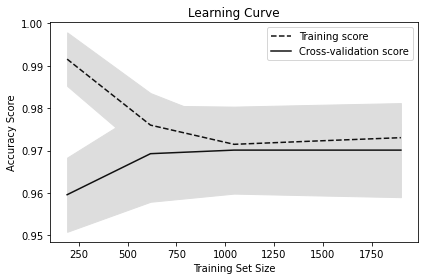

In [19]:
plot_learning_curve(classifier,X_train,y_train,5)

- confusion matrix of logistic regression.

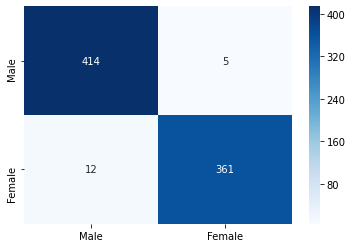

In [20]:
plot_confusion_matrix(y_test, y_pred)

k. Fitting Random Forest Classifier to the Training set.

In [21]:
from sklearn.ensemble import RandomForestClassifier
n_estimator = [5,10,20,30,40,50]
criterion = ['gini','entropy']
scoresDf3 = gridSearch(RandomForestClassifier(random_state=0),X_train,y_train,X_test,y_test,n_estimator,criterion)

In [22]:
scoresDf3.sort_values(by = 'accuracy',ascending=False)

,model_name,accuracy,params
5,RandomForestClassifier,0.986111,"(20, entropy)"
6,RandomForestClassifier,0.983586,"(30, gini)"
11,RandomForestClassifier,0.983586,"(50, entropy)"
10,RandomForestClassifier,0.982323,"(50, gini)"
2,RandomForestClassifier,0.981061,"(10, gini)"
8,RandomForestClassifier,0.981061,"(40, gini)"
4,RandomForestClassifier,0.979798,"(20, gini)"
7,RandomForestClassifier,0.979798,"(30, entropy)"
9,RandomForestClassifier,0.979798,"(40, entropy)"
3,RandomForestClassifier,0.978535,"(10, entropy)"


In [23]:
classifier = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9861111111111112


- learning curve of random forest classifier.

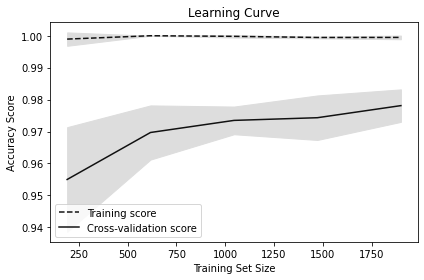

In [24]:
plot_learning_curve(classifier,X_train,y_train,5)

- confusion matrix of random forest classifier.

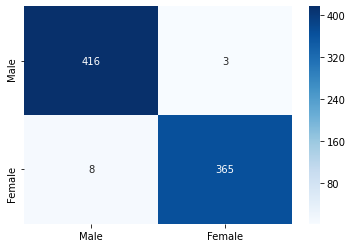

In [25]:
# Making the Confusion Matrix
plot_confusion_matrix(y_test, y_pred)


<a id='feature_extraction'></a>
### Part III - Feature extraction

a. Getting the top 10 features that have a good correlations with labels.

In [27]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(SVC(kernel='rbf',C=20,gamma='scale',random_state=0), 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X, y)
sfs1.subsets_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.6s finished

[2020-12-11 00:17:25] Features: 1/10 -- score: 0.9532828282828283[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.5s finished

[2020-12-11 00:17:28] Features: 2/10 -- score: 0.9706439393939394[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.1s finished

[2020-12-11 00:17:30] Features: 3/10 -- score: 0.9775883838383839[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

{1: {'feature_idx': (12,),
  'cv_scores': array([0.95328283]),
  'avg_score': 0.9532828282828283,
  'feature_names': ('12',)},
 2: {'feature_idx': (5, 12),
  'cv_scores': array([0.97064394]),
  'avg_score': 0.9706439393939394,
  'feature_names': ('5', '12')},
 3: {'feature_idx': (5, 9, 12),
  'cv_scores': array([0.97758838]),
  'avg_score': 0.9775883838383839,
  'feature_names': ('5', '9', '12')},
 4: {'feature_idx': (5, 9, 12, 19),
  'cv_scores': array([0.98011364]),
  'avg_score': 0.9801136363636364,
  'feature_names': ('5', '9', '12', '19')},
 5: {'feature_idx': (5, 9, 10, 12, 19),
  'cv_scores': array([0.98137626]),
  'avg_score': 0.9813762626262627,
  'feature_names': ('5', '9', '10', '12', '19')},
 6: {'feature_idx': (3, 5, 9, 10, 12, 19),
  'cv_scores': array([0.98295455]),
  'avg_score': 0.9829545454545454,
  'feature_names': ('3', '5', '9', '10', '12', '19')},
 7: {'feature_idx': (3, 4, 5, 9, 10, 12, 19),
  'cv_scores': array([0.98390152]),
  'avg_score': 0.9839015151515151,
 

In [40]:
selected_features = voice.iloc[:,[3, 4, 5, 9, 10, 12, 14, 19,-1]]


b. importing dataset after feature selection.

In [41]:
X = selected_features.iloc[:,:-1].values
y = selected_features.iloc[:,-1:].values

In [42]:
oneHotEncoder = OneHotEncoder(sparse=False)
y = oneHotEncoder.fit_transform(y)
y_final = []
for z in y:
    y_final.append(z[0])
y = y_final

c.Splitting the dataset into the Training set and Test set after feature selection.

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

d.Fitting SVM to the Training set after feature selection.

In [45]:
from sklearn.svm import SVC
kernel =  ['rbf','linear','sigmoid']
C = [1,10,20]
scoresDf = gridSearch(SVC(random_state = 0),X_train,y_train,X_test,y_test,kernel,C)

In [46]:
scoresDf.sort_values(by='accuracy',ascending=False)

,model_name,accuracy,params
0,SVC,0.982323,"(rbf, 1)"
1,SVC,0.979798,"(rbf, 10)"
2,SVC,0.979798,"(rbf, 20)"
3,SVC,0.976010,"(linear, 1)"
4,SVC,0.974747,"(linear, 10)"
5,SVC,0.974747,"(linear, 20)"
8,SVC,0.862374,"(sigmoid, 20)"
6,SVC,0.839646,"(sigmoid, 1)"
7,SVC,0.824495,"(sigmoid, 10)"


In [47]:
classifier = SVC(kernel='rbf',C=1,gamma='scale',random_state=0)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
metrics.accuracy_score(y_test,y_pred)

0.9823232323232324

- learning curve of SVC after feature selection.

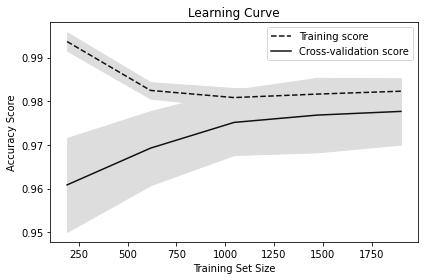

In [48]:
plot_learning_curve(classifier,X_train,y_train,5)

- confusion matrix of SVC after feature selection.

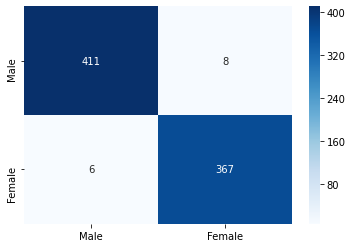

In [49]:
plot_confusion_matrix(y_test, y_pred)

e. Fitting Logistic Regression to the Training set after feature selection.

In [50]:
from sklearn.linear_model import LogisticRegression
solver= ['newton-cg','lbfgs','liblinear', 'sag', 'saga']
penalty =['l2']
scoresDf2 = gridSearch(LogisticRegression(random_state=0),X_train,y_train,X_test,y_test,penalty,solver)

In [51]:
scoresDf2.sort_values(by='accuracy',ascending=False)

,model_name,accuracy,params
0,LogisticRegression,0.974747,"(l2, newton-cg)"
1,LogisticRegression,0.974747,"(l2, lbfgs)"
2,LogisticRegression,0.974747,"(l2, liblinear)"
3,LogisticRegression,0.974747,"(l2, sag)"
4,LogisticRegression,0.974747,"(l2, saga)"


In [52]:
classifier = LogisticRegression(solver='lbfgs',penalty='l2',random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9747474747474747


- learning curve of Logistic Regression after feature selection.

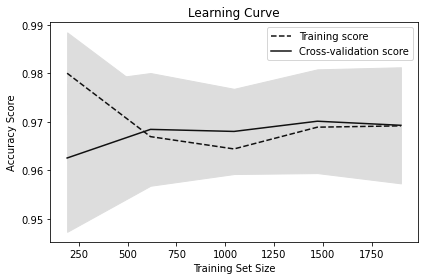

In [53]:
plot_learning_curve(classifier,X_train,y_train,5)

- Confusion Matrix of Logistic Regression after feature selection.

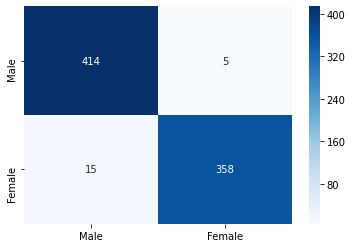

In [54]:
plot_confusion_matrix(y_test, y_pred)

f. Fitting Random Forest Classifier to the Training set after feature selection.

In [55]:
from sklearn.ensemble import RandomForestClassifier
n_estimator = [5,10,20,30,40,50]
criterion = ['gini','entropy']
scoresDf3 = gridSearch(RandomForestClassifier(random_state=0),X_train,y_train,X_test,y_test,n_estimator,criterion)

In [56]:
scoresDf3.sort_values(by = 'accuracy',ascending=False)

,model_name,accuracy,params
3,RandomForestClassifier,0.982323,"(10, entropy)"
9,RandomForestClassifier,0.982323,"(40, entropy)"
2,RandomForestClassifier,0.979798,"(10, gini)"
5,RandomForestClassifier,0.979798,"(20, entropy)"
8,RandomForestClassifier,0.979798,"(40, gini)"
10,RandomForestClassifier,0.979798,"(50, gini)"
11,RandomForestClassifier,0.979798,"(50, entropy)"
4,RandomForestClassifier,0.978535,"(20, gini)"
6,RandomForestClassifier,0.978535,"(30, gini)"
7,RandomForestClassifier,0.978535,"(30, entropy)"


In [58]:
classifier = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score:
0.9823232323232324


- learning curve of Random Forest Classifier after feature selection.

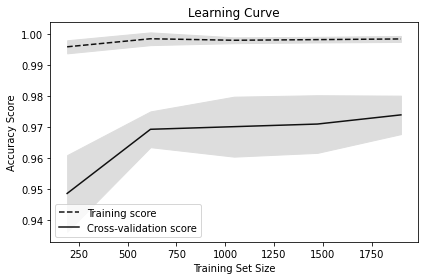

In [59]:
plot_learning_curve(classifier,X_train,y_train,5)

- Confusion Matrix of Random Forest Classifier after feature selection.

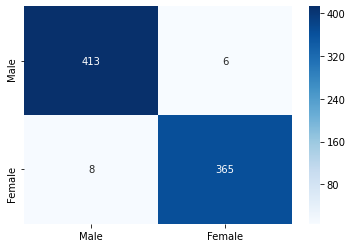

In [60]:
plot_confusion_matrix(y_test, y_pred)
